# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4198.670064,0.9999,-131.886217,2013.72,1881.833783
OMUSDT,526.319895,1815.942011,0.4325,0.000000,1289.62,1289.620000
BTCUSDT,601.021649,899.135163,0.2141,3.537078,298.11,301.647078
JASMYUSDT,387.458505,609.709700,0.1452,0.000000,222.25,222.250000
SOLUSDT,281.200518,401.632196,0.0957,0.000000,120.43,120.430000
ETHUSDT,250.747339,272.179842,0.0648,0.000000,21.43,21.430000
TRXUSDT,76.868953,140.811160,0.0335,-10.723889,63.94,53.216111
BBUSDT,60.176053,58.019838,0.0138,-39.733101,-2.16,-41.893101
BNBUSDT,1.142121,1.240147,0.0003,-10.606040,0.10,-10.506040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [19]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [20]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [21]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [22]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-08    111.313093
2024-12-09   -518.407294
2024-12-10    169.223224
2024-12-11    263.766653
2024-12-12   -134.094487
Name: Total, Length: 81, dtype: float64

In [23]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

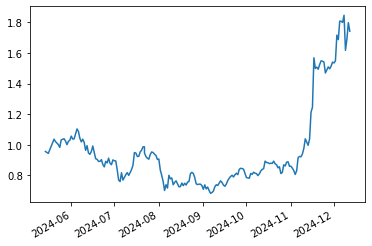

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3745
BNBUSDT,0.1658
PEPEUSDT,0.1284
SUIUSDT,0.1015
TRXUSDT,0.0835
XRPUSDT,0.0693
XLMUSDT,0.0387
JASMYUSDT,0.0384
ALGOUSDT,0.0000
ADAUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.358490
BTCUSDT,0.300000
PEPEUSDT,0.093337
SUIUSDT,0.080406
TRXUSDT,0.073418
JASMYUSDT,0.029932
XLMUSDT,0.027003
XRPUSDT,0.018908
BNBUSDT,0.018505


### Current results

In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.411920
OMUSDT,0.333264
TRXUSDT,0.210932
PEPEUSDT,0.043884


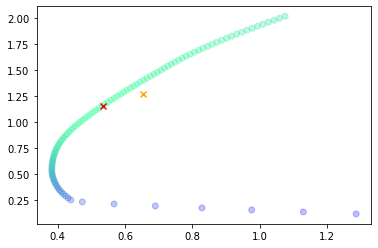

In [39]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1815.942011,0.432504,0.333264,0.099240
BTCUSDT,899.135163,0.214148,0.411920,-0.197772
JASMYUSDT,609.709700,0.145215,0.000000,0.000000
SOLUSDT,401.632196,0.095657,0.000000,0.000000
ETHUSDT,272.179842,0.064825,0.000000,0.000000
TRXUSDT,140.811160,0.033537,0.210932,-0.177395
BBUSDT,58.019838,0.013819,0.000000,0.000000
BNBUSDT,1.240147,0.000295,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.043884,-0.043884


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1815.942011,0.432504,0.358490,0.074014
BTCUSDT,899.135163,0.214148,0.300000,-0.085852
JASMYUSDT,609.709700,0.145215,0.029932,0.115283
SOLUSDT,401.632196,0.095657,0.000000,0.000000
ETHUSDT,272.179842,0.064825,0.000000,0.000000
TRXUSDT,140.811160,0.033537,0.073418,-0.039881
BBUSDT,58.019838,0.013819,0.000000,0.000000
BNBUSDT,1.240147,0.000295,0.018505,-0.018210
PEPEUSDT,0.000006,0.000000,0.093337,-0.093337
SUIUSDT,0.000000,0.000000,0.080406,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

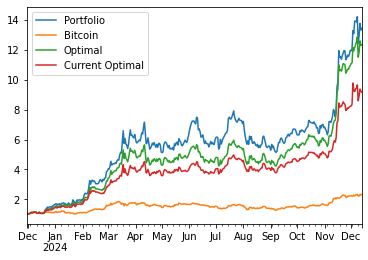

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

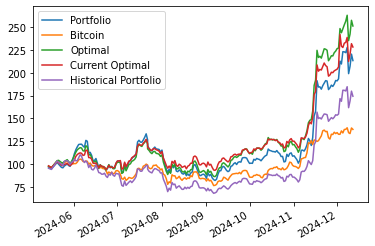

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-03,212.650052,132.715937,248.241145,241.705686,171.684779
2024-12-04,209.532391,136.453406,243.705860,228.987108,168.792541
2024-12-05,222.958711,134.162033,248.139841,227.532482,180.882889
2024-12-06,222.800747,137.975577,252.283853,232.248722,180.754476
2024-12-07,221.905425,138.101611,256.205633,233.091621,180.041463
2024-12-08,227.606236,139.857753,262.751258,238.543463,184.701345
2024-12-09,198.977068,134.452552,235.017783,212.332754,161.779517
2024-12-10,207.008790,133.504547,242.189143,220.347608,169.133901
2024-12-11,220.295537,139.625877,257.254143,231.711067,179.858235
2024-12-12,213.256349,138.069846,251.010805,228.055673,174.270669


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.632522
 dtype: float64,
 0.6333290349067967)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.653616
 dtype: float64,
 0.6536158328660082)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.717070
Bitcoin            0.435067
Optimal            0.633329
Current Optimal    0.579350
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4668041013339808

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.031342,0.018505,0.002393,0.006766,0.000197,0.006569
BTCUSDT,0.400914,0.300000,0.033646,0.138330,0.042471,0.095859
JASMYUSDT,0.088162,0.029932,0.005669,0.022689,0.002839,0.019851
OMUSDT,18.332698,0.358490,0.897245,0.634556,0.527325,0.107231
PEPEUSDT,0.574904,0.093337,0.032078,0.098853,0.034996,0.063857
SUIUSDT,0.249909,0.080406,0.015856,0.055687,0.014850,0.040836
TRXUSDT,0.078732,0.073418,0.007304,0.023451,0.006444,0.017007
XLMUSDT,0.039174,0.027003,0.003177,0.011246,0.001088,0.010158
XRPUSDT,0.035919,0.018908,0.002632,0.008422,0.000393,0.008029


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.845315,0.333264,0.527411,0.579657,0.450702,0.128955
BTCUSDT,0.207072,0.411920,0.276997,0.200437,0.101424,0.099012
TRXUSDT,0.159619,0.210932,0.165821,0.179410,0.122302,0.057108
PEPEUSDT,0.022643,0.043884,0.029771,0.040496,0.008206,0.032290


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.101700,0.434343,0.651964,0.637307,0.510508,0.126800
BTCUSDT,0.106633,0.212121,0.135293,0.084707,0.017935,0.066772
JASMYUSDT,0.090682,0.151515,0.102799,0.157014,0.064588,0.092427
SOLUSDT,0.027984,0.101010,0.054751,0.070406,0.009897,0.060510
ETHUSDT,0.010563,0.060606,0.030207,0.028088,0.002578,0.025511
TRXUSDT,0.022931,0.030303,0.022595,0.011912,0.001683,0.010229
BBUSDT,-0.004467,0.010101,0.002391,0.010564,0.000395,0.010169


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05107384005860992, -0.07529991972005956)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048924425115167876, -0.07528227538831213)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.016900
BTCUSDT     -0.010869
JASMYUSDT   -0.012306
SOLUSDT     -0.007700
ETHUSDT      0.000953
TRXUSDT     -0.001889
BBUSDT      -0.000126
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048836
Name: 2024-11-25 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.041122
BTCUSDT     -0.007319
JASMYUSDT   -0.013495
SOLUSDT     -0.006867
ETHUSDT     -0.002453
TRXUSDT     -0.000939
BBUSDT      -0.000884
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.073078
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06562304601113787, -0.08411060121891775)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06772508366063854, -0.0868048323043552)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05870211411281715, -0.07451501509479877)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06188085378570338, -0.07928920523787934)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.037042
BTCUSDT     -0.005500
JASMYUSDT   -0.011509
SOLUSDT     -0.004966
ETHUSDT     -0.002184
TRXUSDT     -0.000808
BBUSDT      -0.000772
Portfolio   -0.062782
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0600239596800488, -0.07583838167037817)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062345433484020864, -0.07951371882293373)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.037872
BTCUSDT     -0.006232
JASMYUSDT   -0.009683
SOLUSDT     -0.005479
ETHUSDT     -0.002157
TRXUSDT     -0.000463
BBUSDT      -0.000830
Portfolio   -0.062715
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05843590489994854, -0.07604908452836906)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06427928429113805, -0.08251664253900295)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.042423
BTCUSDT     -0.005289
JASMYUSDT   -0.008960
SOLUSDT     -0.004299
ETHUSDT     -0.001723
TRXUSDT     -0.000567
BBUSDT      -0.000694
Portfolio   -0.063957
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10895158592937516, -0.15297168473750156)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10679749699369018, -0.1515243570596168)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.093135
BTCUSDT     -0.001774
JASMYUSDT   -0.013081
SOLUSDT     -0.001370
ETHUSDT     -0.000297
TRXUSDT     -0.000193
BBUSDT       0.000166
Portfolio   -0.109683
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06525827365205082, -0.0822822231466971)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06867242209266818, -0.08591162803402412)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.045208
BTCUSDT     -0.005498
JASMYUSDT   -0.010633
SOLUSDT     -0.004370
ETHUSDT     -0.001897
TRXUSDT     -0.000949
BBUSDT      -0.000682
Portfolio   -0.069237
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054808,-0.091222,-0.081716,-0.026022
2024-01-15,-0.054808,-0.091241,-0.078084,0.018352
2024-01-16,-0.054808,-0.090822,-0.078394,0.039998
2024-01-17,-0.054808,-0.092465,-0.075342,-0.026529
2024-01-18,-0.054808,-0.095345,-0.086304,-0.040220
...,...,...,...,...
2024-12-09,-0.089722,-0.126382,-0.104803,-0.105550
2024-12-10,-0.089722,-0.126108,-0.105437,0.030514
2024-12-11,-0.089722,-0.126044,-0.107010,0.062203
2024-12-12,-0.089722,-0.127478,-0.112322,-0.024269


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034727,-0.085328,-0.078852,-0.017958
2024-05-29,-0.034727,-0.082618,-0.077787,-0.008794
2024-05-30,-0.034727,-0.072898,-0.068037,0.041995
2024-05-31,-0.034727,-0.073978,-0.066505,0.039965
2024-06-01,-0.034727,-0.077507,-0.068576,0.053301
...,...,...,...,...
2024-12-09,-0.115011,-0.114996,-0.111497,-0.125784
2024-12-10,-0.110227,-0.111603,-0.100545,0.040365
2024-12-11,-0.110227,-0.116274,-0.102563,0.064184
2024-12-12,-0.112648,-0.119390,-0.106787,-0.031953


<AxesSubplot:>

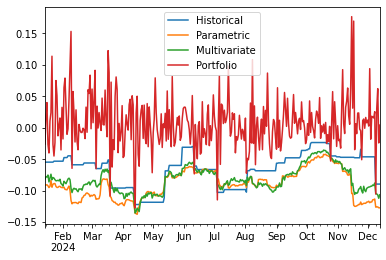

In [80]:
var_data.plot()

<AxesSubplot:>

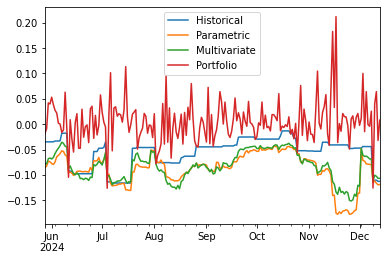

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026866,0.008955,0.014925
Kupiec Stat,4.506088,17.766978,11.838972
P-value,0.033774,0.000025,0.00058


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.065,0.02,0.015
Kupiec Stat,0.869091,4.857184,7.030948
P-value,0.351207,0.027531,0.008011


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76818513, 0.07399739, 0.05898712, 0.05287542, 0.04595494])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014892
ADAUSDT     0.015209
ALGOUSDT    0.017091
APTUSDT     0.016105
ARBUSDT     0.016914
              ...   
WBTCUSDT    0.009295
WLDUSDT     0.021936
XLMUSDT     0.012068
XRPUSDT     0.010599
XTZUSDT     0.016044
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

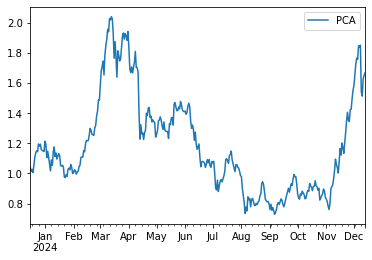

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

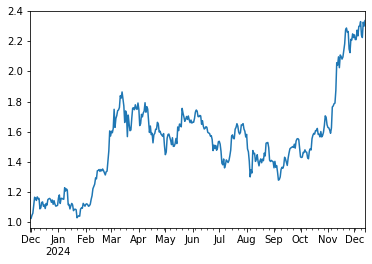

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.418125
WBETHUSDT    0.419444
ETHUSDT      0.419473
ATOMUSDT     0.446779
               ...   
FLOKIUSDT    1.123818
BONKUSDT     1.130424
WLDUSDT      1.133840
PEPEUSDT     1.182522
OMUSDT       1.532446
Length: 64, dtype: float64

<AxesSubplot:>

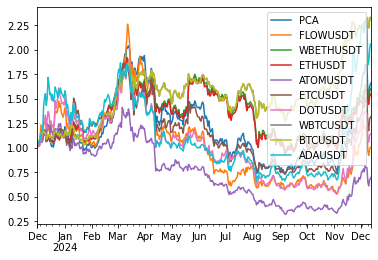

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

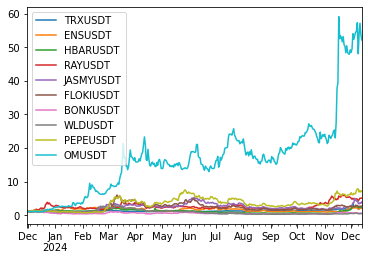

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53092796, 0.15424697, 0.13511816, 0.1026448 , 0.07706211])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.102481
BTCUSDT      0.061696
JASMYUSDT    0.167287
SOLUSDT      0.101246
ETHUSDT      0.082721
TRXUSDT      0.048837
BBUSDT       0.213530
BNBUSDT      0.067837
PEPEUSDT     0.154364
Name: PC1, dtype: float64

<AxesSubplot:>

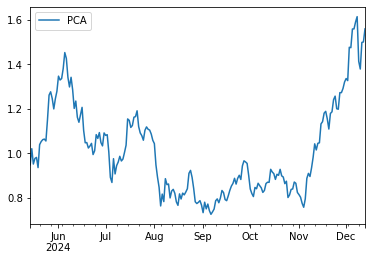

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

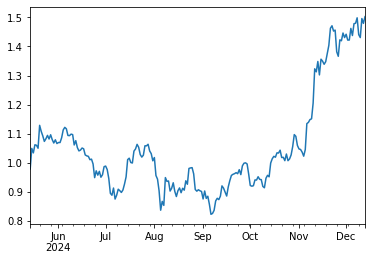

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.387750
ETHUSDT      0.406264
BNBUSDT      0.410707
BTCUSDT      0.425791
JASMYUSDT    0.647943
PEPEUSDT     0.712318
BBUSDT       0.724753
OMUSDT       0.880273
TRXUSDT      0.881183
dtype: float64

<AxesSubplot:>

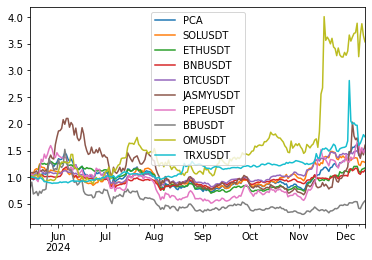

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.898935
BBUSDT       1.574530
JASMYUSDT    1.247039
SOLUSDT      1.145415
BTCUSDT      1.000000
ETHUSDT      0.956281
OMUSDT       0.890813
BNBUSDT      0.664131
TRXUSDT      0.264024
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.294542
PEPEUSDT     1.659348
ETHUSDT      1.335545
OMUSDT       1.058503
SOLUSDT      1.044743
BNBUSDT      1.034174
BTCUSDT      1.000000
JASMYUSDT    0.239025
TRXUSDT     -0.094866
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.889050
ETHUSDT,0.419864
BBUSDT,0.313555
JASMYUSDT,0.119242
OMUSDT,0.097148
TRXUSDT,0.026489
BNBUSDT,0.010893
PEPEUSDT,-0.121933
SOLUSDT,-0.410959


### Regression to PCA

In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.7173361625382214

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.254347
BNBUSDT      1.107184
PCA          1.000000
ETHUSDT      0.974385
SOLUSDT      0.798042
JASMYUSDT    0.402321
PEPEUSDT     0.366748
BBUSDT       0.349023
OMUSDT       0.232372
TRXUSDT      0.179443
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.776093
ETHUSDT      1.225511
SOLUSDT      1.089033
PCA          1.000000
BNBUSDT      0.811986
BBUSDT       0.551096
OMUSDT       0.530468
JASMYUSDT    0.154503
TRXUSDT      0.104855
PEPEUSDT     0.074261
dtype: float64

### Correlation Matrix

<AxesSubplot:>

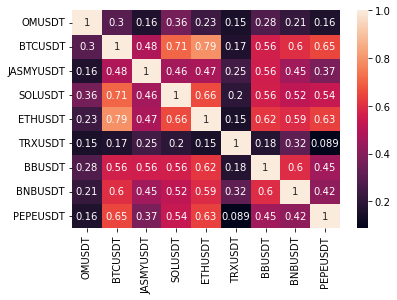

In [104]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<AxesSubplot:>

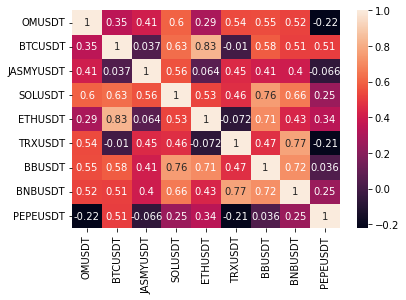

In [105]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-07,0.000000,0.000000,0.0,0.000000,0.0,0.47808,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-06-06,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.014952,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-07-06,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.998900,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-08-05,0.449663,0.022434,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.281547,0.0
2024-09-04,0.000000,0.000004,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.078566,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004221,0.0
2024-10-04,0.000000,0.000000,0.0,0.088538,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.444925,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-03,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.574478,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-03,0.000000,0.061924,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.047615,0.0,0.0,0.0,0.0,0.0,0.0,0.011716,0.165830,0.0
2024-12-13,0.018888,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

FDUSDUSDT    0.967236
AAVEUSDT     0.018888
PEPEUSDT     0.010570
JASMYUSDT    0.003306
WLDUSDT      0.000000
               ...   
GALAUSDT     0.000000
GRTUSDT      0.000000
HBARUSDT     0.000000
ICPUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-13 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

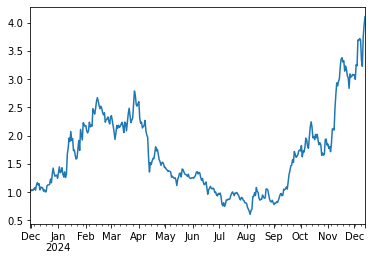

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()